In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk 
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import random
import warnings

warnings.filterwarnings(action='ignore')
random.seed(1121)

/Users/injo/opt/anaconda3/envs/doc2vec/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
raw_data = pd.read_csv('data/2019-2020.csv')

meaning_columns = ['Title', 'Abstract', 'Author Keywords', 'Index Keywords']
data = raw_data[meaning_columns]
data.head()


,Title,Abstract,Author Keywords,Index Keywords
0,Energy efficient and low-cost server architect...,This paper proposes the Lempel-Ziv 4(LZ4) comp...,Data Compression; Hadoop Storage; Hardware Acc...,Acceleration; Costs; Digital storage; Energy e...
1,The effects of cobalt phthalocyanine and polya...,A catalyst capable of high performance and goo...,Cobalt phthalocyanine; H2O2 fuel cell; Hydroge...,Cobalt; Fuel cells; Graphene; Hydrogen peroxid...
2,An accurate weight binarization scheme for CNN...,"Recently, convolutional neural network (CNN)-b...",Binarization; Binary weight; Object detector; ...,NaN
3,Dielectric property characterisation of thin f...,A new research on characterising the dielectri...,NaN,Coplanar waveguides; Dielectric properties of ...
4,Mesoporous Mg-doped hydroxyapatite nanorods pr...,The most important problem in post orthopedic ...,A; B; D. Apatite; E. Biomedical applications; ...,Crystal structure; Hydroxyapatite; Morphology;...


maximum text length : 3285


Text(0.5, 6.79999999999999, 'length of document')

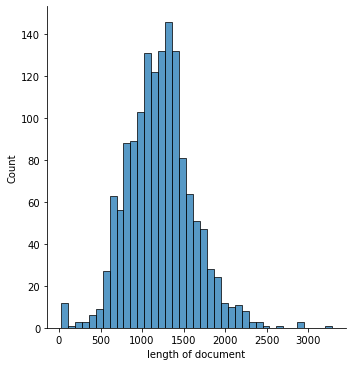

In [3]:
text_length = [len(row['Abstract']) for _, row in data.iterrows()]
print('maximum text length : {}'.format(max(text_length)))
sns.displot(text_length)
plt.xlabel('length of document')

- 엑셀의 셀에 할당되는 최대 텍스트 길이 : 32,767자
- 본 데이터의 최대 길이 : 3,285자

---

# 2. Text preprocessing

In [4]:
string_data = [str(row['Title']) + ' ' + str(row['Abstract']) + ' ' + str(row['Author Keywords']) + ' ' + str(row['Index Keywords']) for _, row in data.iterrows()]
print(string_data[0])

Energy efficient and low-cost server architecture for hadoop storage appliance This paper proposes the Lempel-Ziv 4(LZ4) compression accelerator optimized for scale-out servers in data centers. In order to reduce CPU loads caused by compression, we propose an accelerator solution and implement the accelerator on an Field Programmable Gate Array(FPGA) as heterogeneous computing. The LZ4 compression hardware accelerator is a fully pipelined architecture and applies 16 dictionaries to enhance the parallelism for high throughput compressor. Our hardware accelerator is based on the 20-stage pipeline and dictionary architecture, highly customized to LZ4 compression algorithm and parallel hardware implementation. Proposing dictionary architecture allows achieving high throughput by comparing input sequences in multiple dictionaries simultaneously compared to a single dictionary. The experimental results provide the high throughput with intensively optimized in the FPGA. Additionally, we compa

- 텍스트 내에 punctuation이나 숫자가 많이 포함되어 있음 
- 이러한 불용어들은 정확한 임베딩을 방해하므로 제거해 줌 

## 2-1. 불용어 및 한글 문자 제거 

- 영어 텍스트 내에 한글 corpus가 포함되어 있음 
    - https://brainy-wedge-8e1.notion.site/SeoulTech-Research-Frontier-14a515308b0846f6b0229b4d875231e2
    - 영어 텍스트 처리에 혼선을 야기하므로 제거<br></br>   
   
- 숫자, punctuation등 영어가 아닌 텍스트 또한 제거<br></br>
   
- 또한 stemming이나 lemmatizing은 doc2vec 모델의 성능 향상에 큰 도움은 되지 않는다는 것이 알려져있음 
    - 최초 모델 제안자 또한 model의 pretrain 당시 굳이 어간 추출 과정은 거치지 않음
    - https://stats.stackexchange.com/questions/374209/pre-processing-lemmatizing-and-stemming-make-a-better-doc2vec 

In [5]:
def text_preprocessing(data) :   
    tokenized_english = []
    processed_data = []

    for idx, corpus in enumerate(data) :
        tokenized_english.append(nltk.regexp_tokenize(corpus.lower(), '[A-Za-z]+'))

    for cor in tokenized_english :
        meaning_words = []
        for word in cor :
            if len(word) > 2 :
                if word not in stopwords.words('english') :
                    meaning_words.append(word)
            
        processed_data.append(meaning_words)

    return processed_data

processed_data = text_preprocessing(string_data)
print(processed_data[0])

['energy', 'efficient', 'low', 'cost', 'server', 'architecture', 'hadoop', 'storage', 'appliance', 'paper', 'proposes', 'lempel', 'ziv', 'compression', 'accelerator', 'optimized', 'scale', 'servers', 'data', 'centers', 'order', 'reduce', 'cpu', 'loads', 'caused', 'compression', 'propose', 'accelerator', 'solution', 'implement', 'accelerator', 'field', 'programmable', 'gate', 'array', 'fpga', 'heterogeneous', 'computing', 'compression', 'hardware', 'accelerator', 'fully', 'pipelined', 'architecture', 'applies', 'dictionaries', 'enhance', 'parallelism', 'high', 'throughput', 'compressor', 'hardware', 'accelerator', 'based', 'stage', 'pipeline', 'dictionary', 'architecture', 'highly', 'customized', 'compression', 'algorithm', 'parallel', 'hardware', 'implementation', 'proposing', 'dictionary', 'architecture', 'allows', 'achieving', 'high', 'throughput', 'comparing', 'input', 'sequences', 'multiple', 'dictionaries', 'simultaneously', 'compared', 'single', 'dictionary', 'experimental', 'res

- 길이가 2이하인 텍스트와 nltk에서 지정된 stopwords를 불용어로 지정하고 제거해줌 
- 아래는 nltk의 불용어 리스트

In [6]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

- Task specific한 불용어 리스트 -> 문헌 데이터에서 많이 사용되는 불용어 찾아보기

---

# 3. Doc2vec 임베딩 

## 3-1. Text tagging

In [ ]:
tagged_data = [TaggedDocument(words=corpus, tags=[str(idx)]) for idx, corpus in enumerate(processed_data)]
print(tagged_data[0])

## 3-2. Build model and train model

In [ ]:
epochs = 500
embedding_size = 32
learning_rate = 0.01
min_learning_rate = 0.00025
dm = 1

model = Doc2Vec(vector_size=embedding_size,
                alpha=learning_rate,
                min_alpha=min_learning_rate,
                min_count=5,
                window=10,
                dm=1)

model.build_vocab(tagged_data)

In [ ]:
for epoch in range(1, epochs+1) :
    if epoch % 10 == 0 :
        print('Epoch : {}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

In [ ]:
model.save('models/210901_32_500.model')

## 3-3. Evaluation
<br>

- doc2vec은 unsupervised learning이므로 정량적인 평가가 힘듬  
- 본 연구에서는 인간의 주관으로도 유사한 텍스트와 유사하지 않은 텍스트 pair를 선정하여, 해당 데이터들간의 유사도를 평가지표로 사용하고자 함 

In [7]:
model = Doc2Vec.load('models/210831_128_500.model')

In [8]:
embedding_vectors = [model.infer_vector(corpus) for corpus in processed_data]

In [9]:
target_paper = [1229, 143, 503, 939, 236, 700]
similar_paper = [230, 144, 195, 1046, 485, 1191]
unsimilar_paper = [255, 258, 494, 397, 5, 1078]

for paper_idx in range(len(target_paper)) :
    print('Target paper title : {}'.format(data.iloc[target_paper[paper_idx], :]['Title']))
    print('Similar paper title : {}'.format(data.iloc[similar_paper[paper_idx], :]['Title']))
    print('Unsimilar paper title : {}'.format(data.iloc[unsimilar_paper[paper_idx], :]['Title']))
    print('-----------------------------------------')

Target paper title : Topic analysis for the fourth industrial revolution using LDA and centrality analysis in Korea
Similar paper title : Automated classification of patents: A topic modeling approach
Unsimilar paper title : Improving the stability of lycopene from chemical degradation in model beverage emulsions: Impact of hydrophilic group size of emulsifier and antioxidant polarity
-----------------------------------------
Target paper title : Mask-Soft Filter Pruning for Lightweight CNN Inference
Similar paper title : Mixture of Deterministic and Stochastic Quantization Schemes for Lightweight CNN
Unsimilar paper title : The fruit of acanthopanax senticosus harms improves arterial stiffness and blood pressure: A randomized, placebo-controlled trial
-----------------------------------------
Target paper title : 4D printing using anisotropic thermal deformation of 3D-printed thermoplastic parts
Similar paper title : A 3D-printed metal column for micro gas chromatography
Unsimilar pap

In [10]:
for paper_idx in range(len(target_paper)) :
    print('target paper name : {}'.format(data.iloc[target_paper[paper_idx], :]['Title']))
    print('similarity between similar document : {:.4f}'.format(cosine_similarity([embedding_vectors[target_paper[paper_idx]]], [embedding_vectors[similar_paper[paper_idx]]])[0][0]))
    print('similarity between unsimilar document : {:.4f}'.format(cosine_similarity([embedding_vectors[target_paper[paper_idx]]], [embedding_vectors[unsimilar_paper[paper_idx]]])[0][0]))
    print('----------------------------------------------------------------------------------------------------------------')

target paper name : Topic analysis for the fourth industrial revolution using LDA and centrality analysis in Korea
similarity between similar document : 0.4879
similarity between unsimilar document : 0.7485
----------------------------------------------------------------------------------------------------------------
target paper name : Mask-Soft Filter Pruning for Lightweight CNN Inference
similarity between similar document : 0.6318
similarity between unsimilar document : 0.5155
----------------------------------------------------------------------------------------------------------------
target paper name : 4D printing using anisotropic thermal deformation of 3D-printed thermoplastic parts
similarity between similar document : 0.5854
similarity between unsimilar document : 0.5062
----------------------------------------------------------------------------------------------------------------
target paper name : A high-throughput and power-efficient fpga implementation of yolo cnn f

- 여기서는 코퍼스 간의 차이가 0.5 ~ 0.6 정도인데, 왜 cosine similarity로 측정하면 0.99대인가...
<br></br>
- docvecs에서 어떤 metric을 이용해 similarity를 측정하는지 확인하려고 하였으나 gensim에서 관련 document를 제공하지 않음

---

# 4. Clustering

In [11]:
kmeans = KMeans(n_clusters=30).fit(embedding_vectors)
clusters = kmeans.labels_

---

# 5. T-SNE visualization

In [12]:
tsne_vectors = TSNE(n_components=2).fit_transform(embedding_vectors)

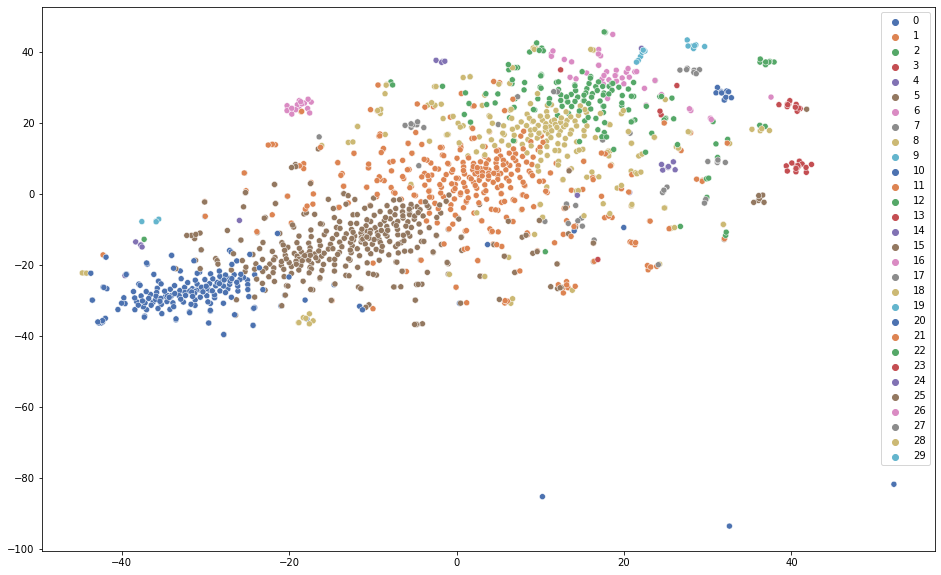

In [13]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(tsne_vectors[:,0], tsne_vectors[:,1], hue=clusters, palette='deep', ax=ax)
plt.show()

- 학습 결과 명확하게 클러스터간의 구분이 발생하는 것을 확인 
- 임베딩이 잘 되었음을 확인 가능

---

# 6. Construct network

In [14]:
network = cosine_similarity(embedding_vectors, embedding_vectors)
for row in range(len(embedding_vectors)) :
    for col in range(len(embedding_vectors)) :
        if row == col :
            network[row, col] = 0

network

array([[0.        , 0.68204933, 0.6460834 , ..., 0.75824046, 0.6682615 ,
        0.7392244 ],
       [0.68204933, 0.        , 0.6243152 , ..., 0.6692054 , 0.55551875,
        0.5595309 ],
       [0.6460834 , 0.6243152 , 0.        , ..., 0.5427505 , 0.556439  ,
        0.51722443],
       ...,
       [0.75824046, 0.6692056 , 0.5427503 , ..., 0.        , 0.64837056,
        0.6740838 ],
       [0.66826147, 0.5555189 , 0.556439  , ..., 0.64837056, 0.        ,
        0.5963041 ],
       [0.73922443, 0.55953085, 0.51722455, ..., 0.6740838 , 0.5963041 ,
        0.        ]], dtype=float32)

- https://stackoverflow.com/questions/52286330/inaccurate-similarities-results-by-doc2vec-using-gensim-library
    - cosine similarity 로 계산시 벡터간의 유사도가 0.99정도로 높게 나오는 것은 당연 

In [15]:
print('most similar vector with doc {}  : {}'.format(1, model.docvecs.most_similar('1')[:5]))
print('---------------')
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[1021]]))
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[778]]))
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[1012]]))
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[255]]))
print('---------------')
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[100]]))
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[200]]))
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[300]]))
print(cosine_similarity([embedding_vectors[1]], [embedding_vectors[400]]))

most similar vector with doc 1  : [('60', 0.7058934569358826), ('1147', 0.7043566703796387), ('774', 0.6893653273582458), ('1123', 0.6874263286590576), ('545', 0.6842314600944519)]
---------------
[[0.41587412]]
[[0.6267171]]
[[0.59979653]]
[[0.79768485]]
---------------
[[0.73116624]]
[[0.7312367]]
[[0.72909296]]
[[0.64557993]]


In [16]:
print('most similar vector with doc {}  : {}'.format(3, model.docvecs.most_similar('3')[:5]))
print('---------------')
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[780]]))
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[453]]))
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[392]]))
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[231]]))
print('---------------')
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[100]]))
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[200]]))
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[300]]))
print(cosine_similarity([embedding_vectors[3]], [embedding_vectors[400]]))

most similar vector with doc 3  : [('341', 0.6249976754188538), ('100', 0.5950305461883545), ('1114', 0.5593327879905701), ('86', 0.5573342442512512), ('806', 0.5546175837516785)]
---------------
[[0.04358935]]
[[-0.08933956]]
[[0.13240108]]
[[-0.01296099]]
---------------
[[0.00659258]]
[[0.01766645]]
[[0.0204437]]
[[0.09172421]]


In [17]:
print('edge의 갯수(weight가 0인 edge의 수) : {}'.format(network.shape[0]))
print('edge weight 의 평균 : {:.4f}'.format(network.mean()))
print('------------------------------------------------------')
print('weight가 0.5 이하인 edge의 갯수 : {}'.format(network[network < 0.50].shape[0]))
print('weight가 0.5 이하인 edge의 비율 : {:.4f}'.format(network[network < 0.50].shape[0] / (network.shape[0]*network.shape[0])))

edge의 갯수(weight가 0인 edge의 수) : 1471
edge weight 의 평균 : 0.4272
------------------------------------------------------
weight가 0.5 이하인 edge의 갯수 : 1114713
weight가 0.5 이하인 edge의 비율 : 0.5152


- 전체 엣지 중 40%가 weight 0.40이하

---

# 7. Network visualization

In [ ]:
threshold = 0.7

network_data = np.where(network >= threshold, network, 0)

G = nx.convert_matrix.from_numpy_array(network_data)
G.remove_nodes_from(list(nx.isolates(G)))
nx.draw(G)

In [ ]:
print(G)

In [ ]:
network_data = pd.DataFrame(network_data, index=list(raw_data.Title), columns=list(raw_data.Title))
network_data.to_csv('network/210831_128_500.csv')

# 8. Check cluster information

In [11]:
attribute = pd.read_csv('network/attribute/0831_128_500.csv')
attribute.head()

,Id,Label,timeset,Degree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,modularity_class
0,Energy efficient and low-cost server architect...,Energy efficient and low-cost server architect...,NaN,311,231.233519,5,0.538141,0.613388,0.001309,0
1,Three-dimensional core–shell structured NiCo2O...,Three-dimensional core–shell structured NiCo2O...,NaN,618,479.173403,4,0.659490,0.757804,0.006810,3
2,Simple P-I diagram for structural components b...,Simple P-I diagram for structural components b...,NaN,746,596.450950,4,0.717190,0.814863,0.002672,1
3,Study on the optimization of gauge expansion f...,Study on the optimization of gauge expansion f...,NaN,569,441.650084,4,0.636413,0.734679,0.000373,3
4,Compact Ultra Wide-Band and Tri-Band Antenna f...,Compact Ultra Wide-Band and Tri-Band Antenna f...,NaN,721,575.522065,4,0.704600,0.803551,0.001593,1


- 네트워크 커뮤니티의 비율 
    - 커뮤니티 1 : 50.24%
    - 커뮤니티 3 : 35.49%
    - 커뮤니티 0 : 3.48%

In [42]:
community_1, community_3, community_0 = {}, {}, {}

for _, row in attribute.iterrows() :
    if row['modularity_class'] == 1 :
        community_1[row['Label']] = data[data['Title']==row['Label']]['Abstract'].item()
    try :
        if row['modularity_class'] == 3 :
            community_3[row['Label']] = data[data['Title']==row['Label']]['Abstract'].item()
    except :
        print('some error occurs')
    if row['modularity_class'] == 0 :
        community_0[row['Label']] = data[data['Title']==row['Label']]['Abstract'].item()

some error occurs


In [43]:
community_0_processed = text_preprocessing(community_0.values())
community_1_processed = text_preprocessing(community_1.values())
community_3_processed = text_preprocessing(community_3.values())

In [44]:
def flatten(data) :
    return_data = []
    for corpus in data : 
        return_data += corpus
    return return_data

In [45]:
community_0_processed = flatten(community_0_processed)
community_1_processed = flatten(community_1_processed)
community_3_processed = flatten(community_3_processed)

In [64]:
def count_value(data) :
    unique = list(set(data))
    return_data = {}
    for chunck in unique :
        return_data[chunck] = data.count(chunck)

    return pd.DataFrame.from_dict(return_data, orient='index', columns=['frequency'])


In [79]:
community_0_count = count_value(community_0_processed).sort_values(by='frequency')
community_1_count = count_value(community_1_processed).sort_values(by='frequency')
community_3_count = count_value(community_3_processed).sort_values(by='frequency')

In [76]:
community_0_count.tail(40)

,frequency
hidden,11
gcms,11
power,11
best,11
also,12
carbon,12
nitrogen,12
visual,12
order,12
result,12


In [77]:
community_1_count.tail(40)

,frequency
water,118
use,121
various,123
higher,124
different,124
increased,125
due,128
network,129
design,129
effect,131


In [78]:
community_3_count.tail(40)

,frequency
three,78
methods,79
increased,79
new,80
effect,81
elsevier,82
size,83
design,85
due,85
one,86


- 상대적으로 규모가 큰 1,3번 커뮤니티는 명확한 주제를 도출하지 못하였으나, 0번 커뮤니티는 'gcms', 'nitrogen'등 명확히 화학 공학 관련 키워드를 많이 내포하고 있음 
- 차후 커뮤니티의 수를 증가 시켜 더 세분화 시킬 경우, 각 커뮤니티 별로 유의미한 주제를 가질 것으로 예측됨
- 다만, 본 연구에서는 커뮤니티 탐지기술보다는 KMeans 등 doc2vec 임베딩 벡터를 기반으로한 클러스터링 알고리즘이 더 나은 성능을 보일 것으로 판단됨